In [1]:
!pip install seaborn[stats] tensorflow 

  Using cached tensorflow-2.16.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached matplotlib-3.8.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scipy-1.13.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp312-cp312-manylinux_2_17_x86_6

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("drive/MyDrive/Colab Data/AutoGluon/PJM_Load_hourly.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])

print(f"MAX Datetime: " + str(max(df['Datetime'])))
print(f"MIN Datetime: " + str(min(df['Datetime'])))

df.set_index('Datetime', inplace=True)
data = df['PJM_Load_MW'].values

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

# Function to create sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw-1):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# # Define sequence length and create sequences
# seq_length = 24  # You can adjust this
# sequences = create_inout_sequences(data_normalized, seq_length)

# # Split data into train and test sets
# X, y = [], []
# for seq, label in sequences:
#     X.append(seq)
#     y.append(label)
# X = np.array(X).reshape(-1, seq_length, 1)
# y = np.array(y).reshape(-1, 1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Extend sequences to predict further into the future
seq_length = 24 * 7 * 2  # Two weeks of historical data for each sequence
prediction_length = 24 * 7  # Predict one week into the future

sequences = create_inout_sequences(data_normalized, seq_length)

# Split data into train and test sets for model training
# Ensure that the test set is the very last part of your data
train_sequences = sequences[:-prediction_length]  # Exclude the last week from training
test_sequences = sequences[-prediction_length:]  # Last week for testing

X_train, y_train = zip(*train_sequences)
X_test, y_test = zip(*test_sequences)

X_train = np.array(X_train).reshape(-1, seq_length, 1)
y_train = np.array(y_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, seq_length, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [ ]:
model = Sequential([
    GRU(100, input_shape=(seq_length, 1), return_sequences=False),  # Increased GRU units
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [ ]:
%%time
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
2022/2022 [==============================] - 296s 145ms/step - loss: 0.0285 - val_loss: 0.0144
Epoch 2/50
2022/2022 [==============================] - 289s 143ms/step - loss: 0.0083 - val_loss: 0.0119
Epoch 3/50
2022/2022 [==============================] - 293s 145ms/step - loss: 0.0068 - val_loss: 0.0092
Epoch 4/50
2022/2022 [==============================] - 288s 143ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 5/50
2022/2022 [==============================] - 288s 143ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 6/50
2022/2022 [==============================] - 289s 143ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 7/50
2022/2022 [==============================] - 287s 142ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 8/50
2022/2022 [==============================] - 288s 142ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/50
2022/2022 [==============================] - 289s 143ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/50
2022/2022 [=======================

In [ ]:
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

6/6 [==============================] - 1s 43ms/step


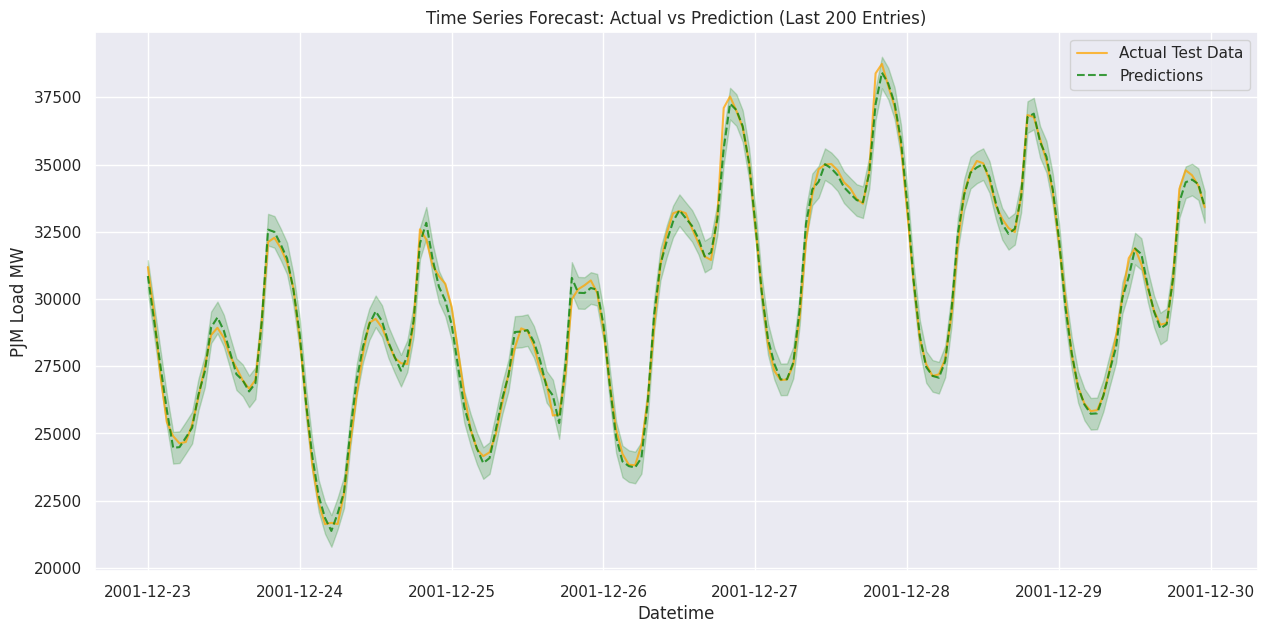

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the last 200 entries for both actual and predicted data
last_entries = 200
test_dates = df.index[-len(y_test):]  # Assumes df.index has been maintained correctly
actual_data = y_test_rescaled[-last_entries:]
predicted_data = y_pred_rescaled[-last_entries:]
test_dates_last_200 = test_dates[-last_entries:]

# Plot settings
sns.set(style="darkgrid")
plt.figure(figsize=(15, 7))

# Plot actual test data
plt.plot(test_dates_last_200, actual_data, label='Actual Test Data', color='orange', alpha=0.75)

# Plot predictions with dashed line
plt.plot(test_dates_last_200, predicted_data, label='Predictions', color='green', linestyle='--', alpha=0.75)

# Calculate and plot confidence intervals (assuming normality for demonstration)
confidence_interval = np.std(predicted_data - actual_data) * 1.96
lower_bounds = (predicted_data - confidence_interval).flatten()
upper_bounds = (predicted_data + confidence_interval).flatten()

plt.fill_between(test_dates_last_200, lower_bounds, upper_bounds, color='green', alpha=0.2)

plt.title('Time Series Forecast: Actual vs Prediction (Last 200 Entries)')
plt.xlabel('Datetime')
plt.ylabel('PJM Load MW')
plt.legend()
plt.show()


In [ ]:
def iterative_forecasts(model, initial_sequence, n_steps):
    """
    Generates future values using the model by recursively using the output as the next input.

    Parameters:
    - model: The trained Keras model.
    - initial_sequence: The last known data sequence to start predictions from.
    - n_steps: Number of future steps to predict.

    Returns:
    - An array of predictions.
    """
    forecast = initial_sequence.copy()  # Copy to avoid altering the original data
    predictions = []

    for _ in range(n_steps):
        # Predict the next step
        next_step = model.predict(forecast.reshape(1, seq_length, 1))
        predictions.append(next_step.flatten()[0])  # Store the predicted value

        # Update the forecast array
        forecast = np.roll(forecast, -1)  # Shift everything one step to the left
        forecast[-1] = next_step  # Insert the predicted value as the last item

    return np.array(predictions)

# Using the last sequence of the training set to predict forward
last_sequence = X_train[-1].reshape(seq_length, 1)
n_future_steps = 24 * 7  # Predict one week ahead
future_predictions = iterative_forecasts(model, last_sequence, n_future_steps)


1/1 [==============================] - 0s 58ms/step


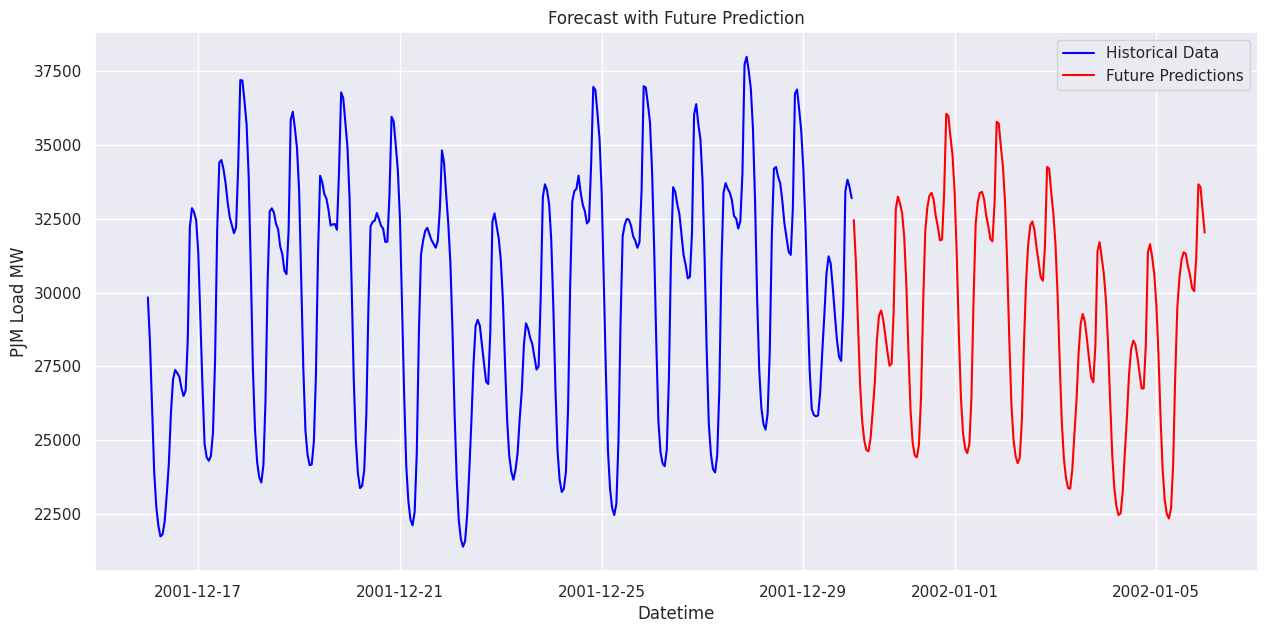

In [ ]:
# Rescale the predictions back to the original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

# Prepare data for plotting
future_dates = pd.date_range(start=df.index[-1], periods=len(future_predictions) + 1, freq='H')[1:]
historical_dates = df.index[-seq_length:]

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(15, 7))

# Historical data for the last two weeks
plt.plot(historical_dates, scaler.inverse_transform(X_train[-1]), label='Historical Data', color='blue')

# Future predictions beyond data boundary
plt.plot(future_dates, future_predictions_rescaled, label='Future Predictions', color='red')

plt.title('Forecast with Future Prediction')
plt.xlabel('Datetime')
plt.ylabel('PJM Load MW')
plt.legend()
plt.show()
